# Ginkgo clustering environment

## Setup

In [1]:
%matplotlib inline

import copy
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
import gym
import logging
from tqdm import trange

from stable_baselines.common.policies import MlpPolicy, MlpLnLstmPolicy
from stable_baselines.deepq import MlpPolicy as DQNMlpPolicy
from stable_baselines import PPO2, ACER, DQN
from stable_baselines.bench import Monitor
from stable_baselines import results_plotter
from stable_baselines.common.env_checker import check_env
from stable_baselines.common.callbacks import BaseCallback

sys.path.append("../")
from ginkgo_rl import GinkgoLikelihoodEnv, GinkgoLikelihood1DEnv, GinkgoLikelihoodShuffledEnv, GinkgoEvaluator
from ginkgo_rl import BatchedACERAgent


/Users/johannbrehmer/opt/miniconda3/envs/rl/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/johannbrehmer/opt/miniconda3/envs/rl/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/johannbrehmer/opt/miniconda3/envs/rl/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/johannbrehme

In [2]:
# Logging setup
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.DEBUG
)

for key in logging.Logger.manager.loggerDict:
    if "ginkgo_rl" not in key:
        logging.getLogger(key).setLevel(logging.ERROR)
        
def set_output(on=True):
    for key in logging.Logger.manager.loggerDict:
        if "ginkgo_rl" in key:
            logging.getLogger(key).setLevel(logging.DEBUG if on else logging.ERROR)


## Let's play a round of clustering manually

In [3]:
set_output(True)
env = GinkgoLikelihoodEnv(n_max=6, illegal_reward=0., min_reward=None)
state = env.reset()
env.render()

15:31 ginkgo_rl.envs.ginkg DEBUG   Initializing environment
15:31 ginkgo_rl.envs.ginkg DEBUG   Resetting environment
15:31 ginkgo_rl.envs.ginkg DEBUG   Sampling new jet with 4 leaves
15:31 ginkgo_rl.envs.ginkg INFO    4 particles:
15:31 ginkgo_rl.envs.ginkg INFO      p[ 0] = (  1.0,   0.4,   0.8,   0.4)
15:31 ginkgo_rl.envs.ginkg INFO      p[ 1] = (  1.9,   1.2,   0.9,   1.2)
15:31 ginkgo_rl.envs.ginkg INFO      p[ 2] = (  0.3,   0.2,   0.2,   0.2)
15:31 ginkgo_rl.envs.ginkg INFO      p[ 3] = (  0.9,   0.5,   0.4,   0.5)


In [4]:
for i, (children, p, log_likelihood_split, delta) in enumerate(zip(
    env.jet['tree'], env.jet['content'], env.jet['logLH'], env.jet['deltas']
)):
    if children[0] < 0 and children[1] < 0:
        print(f"{i}: {p}. Leaf.")
    else:
        print(f"{i}: {p}. {i} -> ({children[0]}, {children[1]}) with log p = {log_likelihood_split}, delta = {delta}")

0: [407.92156109 230.94010768 230.94010768 230.94010768]. 0 -> (1, 2) with log p = -14.728787422180176, delta = 6400.0
1: [103.06200827  42.5980643   83.89093116  42.01959462]. Leaf.
2: [304.85955282 188.34204338 147.04917651 188.92051306]. 2 -> (3, 4) with log p = -7.743199348449707, delta = 152.20106506347656
3: [188.05934772 115.35438905  89.89876723 118.16351731]. Leaf.
4: [116.8002051   72.98765433  57.15040929  70.75699575]. 4 -> (5, 6) with log p = -3.702552080154419, delta = 42.368507385253906
5: [31.65752166 18.98944649 16.13404677 19.33101214]. Leaf.
6: [85.14267916 53.99820516 41.01636042 51.42598101]. Leaf.


In [5]:
# Merge two particles
action = 0, 1

state, reward, done, info = env.step(action)
env.render()

print(f"Reward: {reward}")
print(f"Done: {done}")
print(f"Info: {info}")

# Repeat this cell as often as you feel like


15:31 ginkgo_rl.envs.ginkg DEBUG   Environment step. Action: (0, 1)
15:31 ginkgo_rl.envs.ginkg DEBUG   Computing log likelihood of action (0, 1): ti = 0.0, tj = 0.0, t_cut = 16.0, lam = 1.5 -> log likelihood = -12.234513282775879
15:31 ginkgo_rl.envs.ginkg DEBUG   Merging particles 0 and 1. New state has 3 particles.
15:31 ginkgo_rl.envs.ginkg INFO    3 particles:
15:31 ginkgo_rl.envs.ginkg INFO      p[ 0] = (  2.9,   1.6,   1.7,   1.6)
15:31 ginkgo_rl.envs.ginkg INFO      p[ 1] = (  0.3,   0.2,   0.2,   0.2)
15:31 ginkgo_rl.envs.ginkg INFO      p[ 2] = (  0.9,   0.5,   0.4,   0.5)


Reward: -12.234513282775879
Done: False
Info: {'legal': True, 'illegal_action_counter': 0, 'replace_illegal_action': False, 'i': 0, 'j': 1}


In [6]:
env.close()

## Env checker

In [7]:
set_output(False)
env = gym.make("GinkgoLikelihoodShuffled-v0")

check_env(env)

for i in range(env.n_max):
    assert i == env.inverse_permutation[env.permutation[i]] == env.permutation[env.inverse_permutation[i]]
    
env.close()

/Users/johannbrehmer/opt/miniconda3/envs/rl/lib/python3.7/site-packages/stable_baselines/common/env_checker.py:202: UserWarning: Your observation has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector
  warnings.warn("Your observation has an unconventional shape (neither an image, nor a 1D vector). "


## Evaluation routine

In [3]:
set_output(False)
evaluator = GinkgoEvaluator()


In [4]:
# True log likelihoods
set_output(False)
evaluator.eval_true("Truth")


In [5]:
# MLE (Trellis)
set_output(False)
evaluator.eval_exact_trellis("ML (Trellis)")


## Random clusterings

In [ ]:
set_output(False)
evaluator.eval_random("Random", env_name="GinkgoLikelihood-v0")


In [ ]:
_ = evaluator.plot_log_likelihoods()

## RL preparation

In [6]:
log_dirs = []
models = {}
env_names = {}

def train_baseline(algorithm, algo_class, policy_class, env_name="GinkgoLikelihoodShuffled1D-v0", n_steps=10000):
    log_dir = f"./logs/{algorithm}/"
    log_dirs.append(log_dir)

    set_output(False)
    env = gym.make(env_name)
    os.makedirs(log_dir, exist_ok=True)
    env = Monitor(env, log_dir)

    model = algo_class(policy_class, env, verbose=0)
    model.learn(total_timesteps=n_steps)
    
    models[algorithm] = model
    env_names[algorithm] = env_name
    env.close()

def train_own(algorithm, algo_class, env_name="GinkgoLikelihoodShuffled1D-v0", n_steps=10000):
    log_dir = f"./logs/{algorithm}/"
    log_dirs.append(log_dir)

    set_output(False)
    env = gym.make(env_name)
    os.makedirs(log_dir, exist_ok=True)
    env = Monitor(env, log_dir)
    _ = env.reset()

    model = algo_class(env)
    model.learn(total_timesteps=n_steps)
    
    models[algorithm] = model
    env_names[algorithm] = env_name
    env.close()


## ACER (our own)

In [7]:
train_own("acer", BatchedACERAgent)

  1%|          | 97/10000 [00:20<38:11,  4.32it/s]/Users/johannbrehmer/work/shower_rl/ToyJetsShower/showerSim/invMass_ginkgo.py:289: RuntimeWarning: invalid value encountered in sqrt
  logger.debug(f"pR inv mass from p^2 in lab  frame: {np.sqrt(pR_mu[0] ** 2 - np.linalg.norm(pR_mu[1::]) ** 2)}")
  9%|▊         | 858/10000 [04:30<57:22,  2.66it/s]  /Users/johannbrehmer/work/shower_rl/ToyJetsShower/showerSim/invMass_ginkgo.py:333: RuntimeWarning: invalid value encountered in sqrt
  P = np.sqrt(tp)/2 * np.sqrt( 1 - 2 * (t_child+t_sib)/tp + (t_child - t_sib)**2 / tp**2 )
100%|██████████| 10000/10000 [41:17<00:00,  4.04it/s] 


## PPO

In [ ]:
train("ppo", PPO2, MlpPolicy, env_name="GinkgoLikelihoodShuffled-v0")

## DQN

In [ ]:
train("dqn", DQN, DQNMlpPolicy)

## Training progress

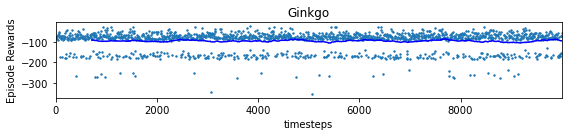

In [8]:
results_plotter.plot_results(log_dirs[:], 1e4, results_plotter.X_TIMESTEPS, "Ginkgo")


## Evaluate

In [ ]:
evaluator.eval("ACER", models["acer"], "GinkgoLikelihoodShuffled1D-v0")

/Users/johannbrehmer/work/shower_rl/ToyJetsShower/showerSim/invMass_ginkgo.py:289: RuntimeWarning: invalid value encountered in sqrt
  logger.debug(f"pR inv mass from p^2 in lab  frame: {np.sqrt(pR_mu[0] ** 2 - np.linalg.norm(pR_mu[1::]) ** 2)}")
/Users/johannbrehmer/work/shower_rl/ToyJetsShower/showerSim/invMass_ginkgo.py:333: RuntimeWarning: invalid value encountered in sqrt
  P = np.sqrt(tp)/2 * np.sqrt( 1 - 2 * (t_child+t_sib)/tp + (t_child - t_sib)**2 / tp**2 )


In [ ]:
evaluator.eval("PPO", models["ppo"], "GinkgoLikelihoodShuffled-v0")

In [ ]:
evaluator.eval("DQN", models["dqn"], "GinkgoLikelihoodShuffled1D-v0")

In [ ]:
_ = evaluator.plot_log_likelihoods()